<a href="https://colab.research.google.com/github/bezzonov/HSE_ML_PRO/blob/main/Hometasks/Pro/HW2_Gradient_descent_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — продвинутая часть**

В этом домашнем задании вы ещё раз закрепите **градиентный спуск**, но уже в модифицированном виде.
Вы реализуете различные виды GD, закрепите на практике их свойства и улучшения и научитесь интерпретировать результаты.


**Дедлайн: 13 декабря 23:59**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

### **Задание 1. Зоопарк оптимизаторов (5 баллов)**


Обычный градиентный спуск с постоянным шагом хорошо работает на простых выпуклых функциях, но резко теряет эффективность, как только ландшафт становится более сложным. В реальности ландшафт сложный всегда — если мы работаем с нейронной сетью — параметров много и функции сложные. В них есть разные проблемы (лучше, чем читать — посмотреть [здесь](https://losslandscape.com/gallery/)):

* узкие долины,
* сильно различающиеся масштабы по координатам,
* плоскости с почти нулевым градиентом,
* рябь, плоскости, седловые точки.

В таких ситуациях стандартный GD перестаёт справляться, поэтому в современной оптимизации почти никогда не используют голый вариант GD. Его заменяют **модифицированные методы**, которые:

* адаптируют шаг обучения под каждую координату,
* сглаживают траекторию накоплением информации о прошлых градиентах,
* корректируют скорость движения в зависимости от геометрии ландшафта.

В этом задании мы будем реализовывать такие методы в единой архитектуре.

#### **Задание 1.1 Реализация золотой пятерки (3 балла)**

Ниже в коде уже реализован общий базовый класс `Optimizer`, который:

* содержит цикл обучения (`fit`),
* считает градиенты,
* сохраняет историю оптимизации,
* контролирует количество итераций,
* передаёт параметры в оптимизатор.

Ваша задача, для каждого типа оптимизатора, реализовать метод:

```python
def step(self, params, gradient, iteration):
    ...
```

Он принимает, текущие параметры, текущий градиент, номер итерации и должен вернуть обновлённые параметры.


#### **Золотая пятерка**

0. **Vanilla Gradient Descent**
   $$w_{t+1} = w_t - \eta\nabla L(w_t)$$
   
   где $\eta$ — шаг обучения, $\nabla L(w_t)$ — градиент в точке $w_t$.

1. **Momentum (градиентный спуск с моментом)** —  накапливаем “скорость” (усреднённый градиент), чтобы сгладить траекторию и ускориться вдоль долины.
  $$v_t = \beta v_{t-1} + (1 - \beta)\nabla L(w_t)$$
  $$w_{t+1} = w_t - \eta v_t$$
   где $v_t$ — скорость, $\beta \in [0,1)$ — коэффициент затухания (исторически 0.9).

2. **Nesterov Accelerated Gradient (NAG, ускоренный градиент Нестерова)** —  градиент вычисляется как бы в точке, куда мы *ещё только собираемся сделать шаг*.

Пусть мы дошли до шага $t$. На этом момент у нас уже есть скорость $v_{t-1}$.
Это — направление, куда алгоритм движет момент. Заметим, что по классическому моментуму наши веса тогда $\hat{w_t} = w_t - \eta v_t$ — куда бы мы пошли по моментуму. Вычислим их и посчитаем градиент в этой точке. Тогда обновление по NAG есть:

  $$\hat{w_t} = w_t - \eta v_{t-1}$$

  $$v_t = \beta v_{t-1} + (1 - \beta) \nabla L(\hat{w_t})$$
  $$w_{t+1} = w_t - \eta v_t$$


**Примечание:**

Усреднение градиента (как в задании с $1-\beta$) — это экспоненциальное сглаживание и оно не является классическим. Обычно — считается накопление (без коэффициента). В задании мы просим сглаживание, чтобы посмотреть и на него. Можете реализовать оба варианта и посмотреть, что лучше.  


3. **AdaGrad** — реализует адаптивный шаг обучения на основе накопления квадратов градиента. Идея такая — ксли по некоторой координате градиенты большие — по ней уменьшать шаг, а если градиенты маленькие → шаг остаётся большим.

$$G_t = G_{t-1} + (\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{G_t+\varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$

где $\varepsilon$ — стабилизация — чтобы не делить на ноль.


4. **RMSprop** — экспоненциальное сглаживание квадратов градиента. Идея тут — убить недостаток AdaGrad —  онслишком быстро уменьшает шаг, поэтому RMSprop заменяет сумму экспоненциальным средним.

$$s_t = \beta s_{t-1} + (1 - \beta)(\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{s_t + \varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$


5. **Adam** — Momentum + RMSprop одновременно. Идейно Adam поддерживает две экспоненциальные скользящие средние:

* $m_t$ — среднее градиентов (как momentum),
* $v_t$ — среднее квадратов градиентов (как RMSprop).

Кроме того, вводится коррекция смещения.

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla L(w_t)$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla L(w_t))^2$$

$$\hat m_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat v_t = \frac{v_t}{1 - \beta_2^t}$$

$$w_{t+1} = w_t - \eta \frac{\hat m_t}{\sqrt{\hat v_t + \varepsilon}}$$



**Для каждого оптимизатора вы должны написать класс, наследуемый от `Optimizer`, и в нем метод `step()` ровно по формулам выше.
Без внешних библиотек, никаких упрощений. При этом:**


* Базовый класс `Optimizer` уже полностью готов, но в нем <font color="red">специально допущено несколько ошибок. Исправьте их.</font>
* Далее ваша задача — лишь реализовать формулы обновления весов в соответствующих классах.
* После реализации протестируйте оптимизаторы (это будет следующее задание).

In [28]:
class Optimizer:
    """Базовый класс для оптимизаторов"""

    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def step(self, params, gradient, iteration):
        """Один шаг оптимизации - должен быть переопределён"""
        raise NotImplementedError

    def fit(self, loss_fn, grad_fn, initial_params):
        params = initial_params.copy()

        for i in range(self.n_iterations):
            gradient = grad_fn(params)

            self.history['params'].append(params.copy())
            self.history['loss'].append(loss_fn(params))
            self.history['gradients'].append(grad_fn(params).copy())

            params = self.step(params, gradient, i)

        self.history['params'].append(params.copy())
        self.history['loss'].append(loss_fn(params))
        self.history['gradients'].append(grad_fn(params))

        return params



class VanillaGD(Optimizer):
    """Обычный градиентный спуск"""

    def step(self, params, gradient, iteration):
    # Код
      if isinstance(params, (list, tuple)):
        return [p - self.learning_rate * g for p, g in zip(params, gradient)]
      else:
        return params - self.learning_rate * gradient



class MomentumGD(Optimizer):
    """GD с momentum"""
    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
    # Код
      if self.velocity is None:
        if isinstance(params, (list, tuple)):
          self.velocity = [0.0 for _ in params]
        else:
          self.velocity = 0.0
      if isinstance(self.velocity, list):
        self.velocity = [self.velocity[i] * self.beta + (1.0 - self.beta) * g for i, g in enumerate(gradient)]
        return [p - self.learning_rate * v for p, v in zip(params, self.velocity)]
      else:
        self.velocity = self.velocity * self.beta + (1.0 - self.beta) * gradient
        return params - self.learning_rate * self.velocity



class NesterovGD(Optimizer):
    """Nesterov Accelerated Gradient"""
    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
    # Код
      if self.velocity is None:
        if isinstance(params, (list, tuple)):
          self.velocity = [0.0 for _ in params]
        else:
          self.velocity = 0.0
      if isinstance(params, (list, tuple)):
        w_new = [p - self.learning_rate * v for p, v in zip(params, self.velocity)]
        grad_new = gradient
        self.velocity = [v * self.beta + (1.0 - self.beta) * g for v, g in zip(self.velocity, grad_new)]
        return [p - self.learning_rate * v for p, v in zip(params, self.velocity)]
      else:
        w_new = params - self.learning_rate * self.velocity
        grad_new = gradient
        self.velocity = self.velocity * self.beta + (1.0 - self.beta) * grad_new
        return params - self.learning_rate * self.velocity



class AdaGrad(Optimizer):
    """AdaGrad optimizer"""
    def __init__(self, learning_rate=0.01, n_iterations=100, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.epsilon = epsilon
        self.accumulated_grad = None

    def step(self, params, gradient, iteration):
    # Код
      if self.accumulated_grad is None:
        if isinstance(params, (list, tuple)):
          self.accumulated_grad = [0.0 for _ in params]
        else:
          self.accumulated_grad = 0.0
      if isinstance(params, (list, tuple)):
        self.accumulated_grad = [v + p ** 2 for p, v in zip(gradient, self.accumulated_grad)]
        lr = [self.learning_rate / np.sqrt(p + self.epsilon) for p in self.accumulated_grad]
        return [p - l * g for p, g, l in zip(params, gradient, lr)]
      else:
        self.accumulated_grad = self.accumulated_grad + gradient ** 2
        self.learning_rate = self.learning_rate / np.sqrt(self.accumulated_grad + self.epsilon)
        return params - self.learning_rate * gradient



class RMSprop(Optimizer):
    """RMSprop optimizer"""
    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.epsilon = epsilon
        self.squared_grad = None

    def step(self, params, gradient, iteration):
    # Код
      if self.squared_grad is None:
        if isinstance(gradient, (list, tuple)):
          self.squared_grad = [0.0 for _ in gradient]
        else:
          self.squared_grad = 0.0
      if isinstance(gradient, (list, tuple)):
        self.squared_grad = [self.beta * sg + (1.0 - self.beta) * (g ** 2) for sg, g in zip(self.squared_grad, gradient)]
        lr = [self.learning_rate / np.sqrt(s + self.epsilon) for s in self.squared_grad]
        return [p - e * g for p, g, e in zip(params, gradient, lr)]
      else:
        self.squared_grad = self.beta * self.squared_grad + (1.0 - self.beta) * (gradient ** 2)
        lr = self.learning_rate / np.sqrt(self.squared_grad + self.epsilon)
        return params - lr * gradient



class Adam(Optimizer):
    """Adam optimizer"""
    def __init__(self, learning_rate=0.01, n_iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None

    def step(self, params, gradient, iteration):
    # Код
      if self.m is None:
        if isinstance(gradient, (list, tuple)):
          self.m = [0.0 for _ in gradient]
        else:
            self.m = 0.0
      if self.v is None:
          if isinstance(gradient, (list, tuple)):
            self.v = [0.0 for _ in gradient]
          else:
            self.v = 0.0
      t = iteration + 1
      if isinstance(gradient, (list, tuple)):
        self.m = [self.beta1 * m + (1.0 - self.beta1) * g for m, g in zip(self.m, gradient)]
        self.v = [self.beta2 * v + (1.0 - self.beta2) * (g ** 2) for v, g in zip(self.v, gradient)]
        m_new = [m / (1.0 - self.beta1 ** t) for m in self.m]
        v_new = [v / (1.0 - self.beta2 ** t) for v in self.v]
        return [p - self.learning_rate * mn / (np.sqrt(vn) + self.epsilon) for p, mn, vn in zip(params, m_new, v_new)]
      else:
        self.m = self.beta1 * self.m + (1.0 - self.beta1) * gradient
        self.v = self.beta2 * self.v + (1.0 - self.beta2) * (gradient ** 2)
        m_new = self.m / (1.0 - self.beta1 ** t)
        v_new = self.v / (1.0 - self.beta2 ** t)
        return params - self.learning_rate * m_new / (np.sqrt(v_new) + self.epsilon)


#### **Задание 1.2 Тестирование золотой пятерки (2 балла)**

Протестируем оптимизиторы на красивой двумерной функции — **функции Растригина (Rastrigin function)**. Почему именно она? На самом деле, существует несколько [популярных функций-тестов](https://en.wikipedia.org/wiki/Test_functions_for_optimization) для функций оптимизации. И все они безумно красивые. Просто эта — [особенно хорошо отражает сложные ландшафты](https://en.wikipedia.org/wiki/Rastrigin_function). Она имеет:

* большое число локальных экстремумов,
* регулярную рябь по всей области,
* хорошо выраженный глобальный минимум.

Её аналитическая форма в двумерном случае:

$$f(x, y) = 20 + x^2 + y^2 - 10(\cos(2\pi x) + \cos(2\pi y))$$

Глобальный минимум:

$$(x^*, y^*) = (0,0), \quad f(x^*, y^*) = 0.$$


**Что сделать в задании:**
1. Реализовать функцию (двумерную) и ее градиент

2. Запустить каждый оптимизатор:

   * записать функцию и её градиент;
   * запустить оптимизиторы из данной стартовой точки (она прописана в коде), с прописанным базовым learning rate.

3. Для каждого метода вывести:

   * итоговые значения аргументов $x$ и $y$,
   * финальное значение функции потерь.


4. Сделать краткий анализ. Можно опираться на вопросы:

   * Какие методы сходятся быстрее?
   * Кто застрял в локальных минимумах?
   * Насколько траектории “дрожат”?
   * Как адаптивные методы корректируют шаг?
   * Какие методы вышли ближе всего к глобальному минимуму?






In [32]:
def rastrigin_function(params, A=10.0):
    """
    Rastrigin function (2D).
    f(x, y) = 2A + x^2 - A cos(2πx) + y^2 - A cos(2πy)
    Глобальный минимум: (0, 0), f = 0.
    """
    # Ваш код здесь
    x, y = float(params[0]), float(params[1])
    return 2*A + x*x + y*y - A*np.cos(2*np.pi*x) - A*np.cos(2*np.pi*y)

def rastrigin_gradient(params, A=10.0):
    """
    Gradient of Rastrigin function.
    ∂f/∂x = 2x + 2πA sin(2πx)
    ∂f/∂y = 2y + 2πA sin(2πy)
    """
    x, y = float(params[0]), float(params[1]) # Ваш код здесь
    dx = 2*x + 2*np.pi*A*np.sin(2*np.pi*x) # Ваш код здесь
    dy = 2*y + 2*np.pi*A*np.sin(2*np.pi*y) # Ваш код здесь
    return [dx, dy] # Ваш код здесь


# Параметры
initial_point = [-1.0, 2.0]  # стартовая точка вдали от минимума — не меняем!
n_iter = 300
loss_fn = lambda w: rastrigin_function(w)
grad_fn = lambda w: rastrigin_gradient(w)

# Создаём оптимизаторы
optimizers = {
    'GD':       VanillaGD(learning_rate=0.05, n_iterations=n_iter),
    'Momentum': MomentumGD(learning_rate=0.05, n_iterations=n_iter, beta=0.9),
    'NAG':      NesterovGD(learning_rate=0.05, n_iterations=n_iter, beta=0.9),
    'AdaGrad':  AdaGrad(learning_rate=0.05,  n_iterations=n_iter),
    'RMSprop':  RMSprop(learning_rate=0.05,  n_iterations=n_iter, beta=0.9),
    'Adam':     Adam(learning_rate=0.05,     n_iterations=n_iter)
}

# Создаём сетку для визуализации
x_range = np.linspace(-5.5, 5.5, 300)
y_range = np.linspace(-5.5, 5.5, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

for i in range(len(x_range)):
    for j in range(len(y_range)):
        Z[j, i] = rastrigin_function(np.array([X[j, i], Y[j, i]]))

# Обучаем все оптимизаторы
results = {}
for name, optimizer in optimizers.items():
    final_params = optimizer.fit(loss_fn, grad_fn, initial_point) # обучение оптимизатора
    results[name] = optimizer.history
    print(f"{name:12s}: Final loss = {rastrigin_function(final_params):.6f}, "
          f"Params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")

print(f"\nГлобальный минимум (True): [0, 0]")

# Визуализация траекторий — если вы ничего не меняли в базовом классе — оно просто запустится
fig_opt = go.Figure()

# Контур функции
fig_opt.add_trace(
    go.Contour(
        x=x_range,
        y=y_range,
        z=np.log10(Z + 1),  # лог по (f + 1), чтобы избежать log(0)
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=3, size=0.1),
        opacity=0.6,
        name='Rastrigin function (log scale)'
    )
)

# Траектории всех оптимизаторов
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']
for idx, (name, history) in enumerate(results.items()):
    trajectory = np.array(history['params'])
    fig_opt.add_trace(
        go.Scatter(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode='lines',
            line=dict(color=colors[idx], width=2),
            name=name
        )
    )

# Глобальный минимум
fig_opt.add_trace(
    go.Scatter(
        x=[0.0], y=[0.0],
        mode='markers',
        marker=dict(size=15, color='yellow', symbol='star',
                    line=dict(color='black', width=2)),
        name='Глобальный минимум'
    )
)

# Стартовая точка
fig_opt.add_trace(
    go.Scatter(
        x=[initial_point[0]], y=[initial_point[1]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Старт'
    )
)

fig_opt.update_layout(
    title="Сравнение оптимизаторов на Rastrigin function",
    xaxis_title="x",
    yaxis_title="y",
    hovermode='closest',
    width=900,
    height=700
)

fig_opt.show()


GD          : Final loss = 86.423278, Params = [-6.4574, 4.9420]
Momentum    : Final loss = 4.974790, Params = [-0.9950, 1.9899]
NAG         : Final loss = 4.974790, Params = [-0.9950, 1.9899]
AdaGrad     : Final loss = 4.974790, Params = [-0.9950, 1.9899]
RMSprop     : Final loss = 5.220721, Params = [-1.0199, 2.0148]
Adam        : Final loss = 4.974790, Params = [-0.9950, 1.9899]

Глобальный минимум (True): [0, 0]


**Ваш анализ здесь**
1. Чего не хватило адаптивным методам? Что с ними произошло?

Адаптивные методы зависят от ГП. В этом их сила и их слабость. С одной стороны за счет кастомных вычислений они могут быстро прийти к хорошему результату, но застрять в локальном минимуме. Сейчас мы видим, что все они немного сблизились с глобальным минимум, но по пути застряли в локальном минимуме из которого не могут выбраться. Если вывести optimizer.history, то увидим, что координаты точки в градиентах меняются на сотые/тысячные, что при округлении означает, что оптимизатор "встал".

2. Почему градиетному спуску так плохо?

Видимо стандартный ГД перепрыгнул глобальный минимум и пошел совсем не нужном направлении

### **Задание 2. Анализ Losses (2 балла)**



В реализации базового класса `Optimizer`, при каждом спуске сохраняются графики loss-функции. Их в процессе обучения мы также анализируем. Напомним, что говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Используйте ваши реализации из заданий 1–2:

1. Постройте графики значения loss, проанализируйте, какие спуски сошлись.
2. Поизменяйте learning rate, обучите спуски ещё и снова выведите лосс. Как learning rate влияет на результат и удалось ли сойтись теперь?

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь — хороший тон — обернуть эксперимент в функцию

In [ ]:
for lr in [0.01, 0.05, 0.1, 0.5]:

  # Ваш код здесь


### **Задание 3. Будь выпуклым (3 балла)**



На протяжении курса вы могли заметить, что мы всегда предпочитаем выпуклые функции потерь. Но насколько это требование жесткое? Давайте рассмотрим простейшую логистическую регрессию.

Модель:

$$p(x; w) = \sigma(z) = \sigma(w^\top x), \quad \sigma(z) = \frac{1}{1 + e^{-z}}.$$

Стандартный log-loss для одного объекта:

$$L_{\log}(p, y) = -\big( y \log p + (1-y)\log(1-p)\big), \quad y \in {0, 1}.$$

Рассмотрим для неё модифицированный loss — без логарифма. Просто опустим его, оставив линейную комбинацию вероятностей.

$$L_{\text{no-log}}(p, y) = -\big( y p + (1-y)(1-p)\big)$$


#### **3. 1. Логарифм? (2 балла)**

Попробуем понять, зачем вообще нам нужен логарифм.

1. Выведите производную logloss'a  без логарифма по $p$ **(только по $p$, по $w$ не надо!)**. Что получилось? Подумайте (погуглите), почему на практике используют логарифм.

2. Сравните качество:

   * обучите логистическую регрессию с обычным log-loss,
   * обучите с модифицированным loss без log,
   * сравните качество моделей. Поясните результаты.

  **В функциях градиенты должны быть уже по W**


In [ ]:
# Генерация данных
X_class, y_class = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=20,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)
X_with_bias = np.column_stack([np.ones(len(X_scaled)), X_scaled])  # добавляем bias-столбец


# Функции для лосса
def sigmoid(z):
    return # Ваш код здесь


# Стандартный логистический log-loss
def logistic_loss(weights, X, y):
    """
    L_log(w) = - mean( y log p + (1-y) log(1-p) ),  p = sigmoid(X w)
    """
    # Ваш код здесь


def logistic_gradient(weights, X, y):
    """
    grad_w L_log(w) = X^T (p - y) / N,  где p = sigmoid(X w)
    """
    # Ваш код здесь

def without_log_loss(weights, X, y):
    """
    Log-loss без логарифма"
        L_no_log(w) = - mean( y p + (1 - y)(1 - p) ), p = sigmoid(X w)
    """
    # Ваш код здесь


def without_log_loss_grad(weights, X, y):
    """
    Градиент L_no_log по w:
        dL/dp = 1 - 2y
        dp/dz = p (1-p)
        z = X w

    grad_w L_no_log = X^T * [ (1 - 2y) * p (1-p) ] / N
    """
    # Ваш код здесь


Проверим результаты.

* далее везде используйте окласс оптимизатора (`VanillaGD`) и одинаковую инициализацию весов;
* для каждой модели реализуйте свои `loss_fn` и `grad_fn` и передайте их в `fit` через `lambda`:

  ```python
  gd_log = VanillaGD(...)
  w_log = gd_log.fit(
      loss_fn=lambda w: logistic_loss(w, X_with_bias, y),
      grad_fn=lambda w: logistic_gradient(w, X_with_bias, y),
      initial_params=initial_weights
  )
  ```

  и аналогично для `no_log_loss` / `no_log_loss_grad`. Так всё заработает.


In [ ]:
initial_weights = np.ones(X_with_bias.shape[1])

# Логистическая регрессия с log-loss
gd_log = VanillaGD(learning_rate=0.5, n_iterations=200)
w_log = # ваш код здесь

# Логистическая регрессия с no-log loss
gd_no = VanillaGD(learning_rate=0.5, n_iterations=200)
w_no = # ваш код здесь

def accuracy(weights):
    p = sigmoid(X_with_bias @ weights)
    y_pred = (p >= 0.5).astype(int)
    return (y_pred == y_class).mean()

print("\n=== Итоговые результаты (VanillaGD) ===")
print(f"log-loss:    final_loss = {logistic_loss(w_log, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_log):.4f}")
print(f"no-log loss: final_loss = {without_log_loss(w_no, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_no):.4f}")


In [ ]:
# ваш код здесь — постройте график лосса


#### **3. 2. И снова анализ (1 балл)**

Подумайте над результатами задания.
- Почему no-log выдал меньший loss? Значит ли это, что мы можем его использовать?
- Что будет, если подобрать гиперпараметр скорости спуска и попробовать другие оптимизаторы?

Реализуйте ваши эксперименты. За каждый — 0.5 балла (суммарно максимум 1 балл).

## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?


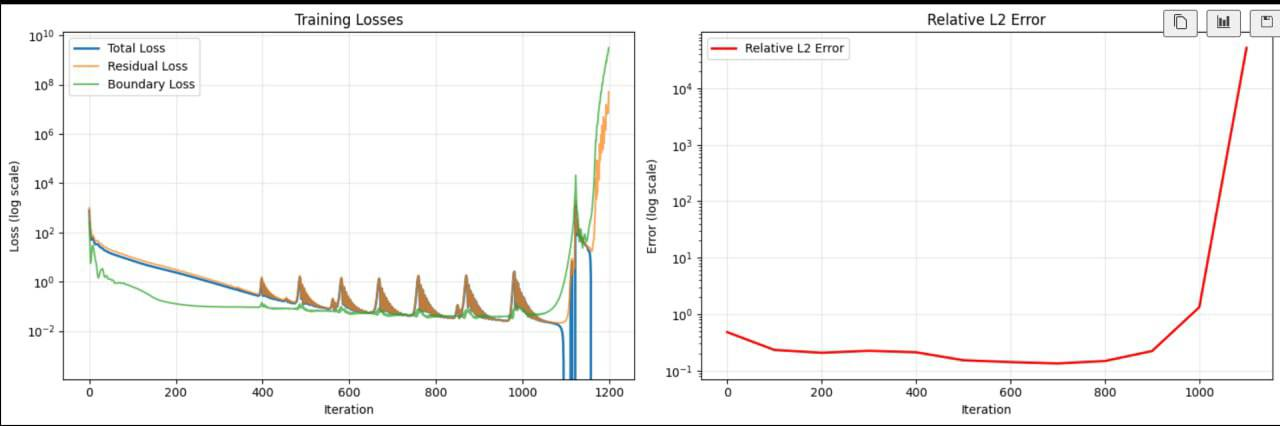